In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as k
from keras import losses
from keras import optimizers
from tensorflow.keras.utils import to_categorical


In [2]:
from keras import backend
from keras.datasets.cifar import load_batch
from keras.utils.data_utils import get_file
from tensorflow.python.util.tf_export import keras_export


@keras_export("keras.datasets.cifar10.load_data")
def load_data():
    dirname = "cifar-10-batches-py"
    origin = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(
        dirname,
        origin=origin,
        untar=True,
        file_hash="6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce", 
    )

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.empty((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        (
            x_train[(i - 1) * 10000 : i * 10000, :, :, :],
            y_train[(i - 1) * 10000 : i * 10000],
        ) = load_batch(fpath)

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if backend.image_data_format() == "channels_last":
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    x_train = x_train[np.where(y_train[:,0]< 3)[0],:]
    y_train = y_train[np.where(y_train[:,0]< 3)[0],:]
    x_test = x_test[np.where(y_test[:,0]< 3)[0],:]
    y_test = y_test[np.where(y_test[:,0]< 3)[0],:]

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    data = (x_train, y_train, x_test, y_test)
    return data

dataGen = load_data()
# print(dataGen[0])

170508288/170498071 [==============================] - 2s 0us/step


In [41]:
num_classes = 3
resnet50 = tf.keras.applications.ResNet50(input_shape=(32, 32, 3), weights=None, classes=num_classes)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [42]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/cifar-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-2)


resnet50.compile(
    loss = losses.categorical_crossentropy ,
    optimizer=adam,
	metrics=["accuracy"]
)

history0 = resnet50.fit(
    dataGen[0], dataGen[1],
    epochs = 200,
    validation_data=(dataGen[2], dataGen[3]),
    callbacks=my_callbacks)

Epoch 1/200
469/469 [==============================] - 28s 48ms/step - loss: 1.7347 - accuracy: 0.5057 - val_loss: 1.0039 - val_accuracy: 0.6533 - lr: 0.0100
Epoch 2/200
469/469 [==============================] - 21s 46ms/step - loss: 0.7704 - accuracy: 0.7182 - val_loss: 0.6117 - val_accuracy: 0.7763 - lr: 0.0100
Epoch 3/200
469/469 [==============================] - 21s 45ms/step - loss: 0.6162 - accuracy: 0.7687 - val_loss: 0.5741 - val_accuracy: 0.7620 - lr: 0.0100
Epoch 4/200
469/469 [==============================] - 20s 43ms/step - loss: 0.5199 - accuracy: 0.8012 - val_loss: 0.6287 - val_accuracy: 0.7493 - lr: 0.0100
Epoch 5/200
469/469 [==============================] - 20s 43ms/step - loss: 0.4677 - accuracy: 0.8182 - val_loss: 0.8653 - val_accuracy: 0.6577 - lr: 0.0100
Epoch 6/200
469/469 [==============================] - 21s 46ms/step - loss: 0.4559 - accuracy: 0.8246 - val_loss: 0.4160 - val_accuracy: 0.8393 - lr: 0.0100
Epoch 7/200
469/469 [==============================]

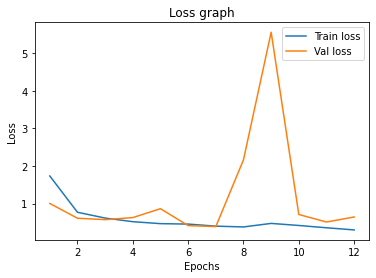

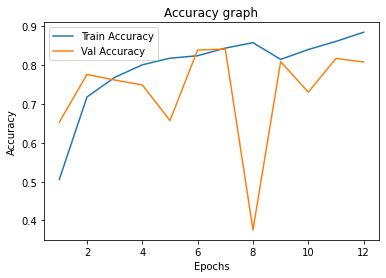

In [43]:
load_fit0 = history0.history
loss = load_fit0['loss']
val_loss = load_fit0['val_loss']
accuracy = load_fit0['accuracy']
val_accuracy = load_fit0['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()

print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [3]:
num_classes = 3
# print(num_classes)
resnet50 = tf.keras.applications.ResNet50(input_shape=(32, 32, 3), weights=None, classes=num_classes)
output_resnet50 = resnet50.get_layer('conv3_block4_add').output

x = tf.keras.layers.Conv2D(128,3,padding="same",name="extra_conv1")(output_resnet50)  
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(64,3,padding="same",name="extra_conv2")(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
# resnet50.summary()



baseNetwork = tf.keras.Model(inputs=resnet50.input,outputs=x,name="basemodel")
baseNetwork.summary()

Model: "basemodel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                          

In [9]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/cifar-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

sgd = tf.keras.optimizers.SGD(1e-4)


baseNetwork.compile(
    loss = losses.categorical_crossentropy ,
    optimizer=sgd,
	metrics=["accuracy"]
)

history1 = baseNetwork.fit(
    dataGen[0], dataGen[1],
    epochs = 200,
    validation_data=(dataGen[2], dataGen[3]),
    callbacks=my_callbacks)

Epoch 1/200
469/469 [==============================] - 10s 17ms/step - loss: 0.8815 - accuracy: 0.6011 - val_loss: 0.7080 - val_accuracy: 0.7193 - lr: 1.0000e-04
Epoch 2/200
469/469 [==============================] - 7s 14ms/step - loss: 0.6649 - accuracy: 0.7291 - val_loss: 0.6206 - val_accuracy: 0.7573 - lr: 1.0000e-04
Epoch 3/200
469/469 [==============================] - 7s 15ms/step - loss: 0.6038 - accuracy: 0.7552 - val_loss: 0.5819 - val_accuracy: 0.7673 - lr: 1.0000e-04
Epoch 4/200
469/469 [==============================] - 7s 15ms/step - loss: 0.5683 - accuracy: 0.7691 - val_loss: 0.5575 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 5/200
469/469 [==============================] - 12s 25ms/step - loss: 0.5431 - accuracy: 0.7817 - val_loss: 0.5387 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 6/200
469/469 [==============================] - 11s 23ms/step - loss: 0.5269 - accuracy: 0.7870 - val_loss: 0.5281 - val_accuracy: 0.7893 - lr: 1.0000e-04
Epoch 7/200
469/469 [==========

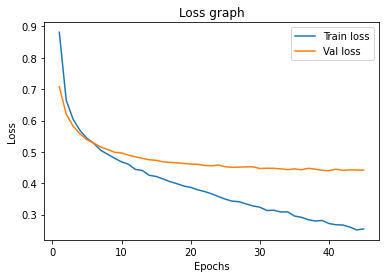

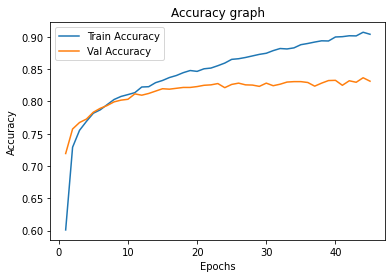

In [10]:
dict1 = history1.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()

print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

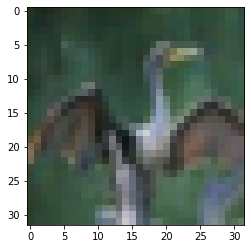

In [26]:
plt.imshow(dataGen[2][54])

In [44]:
from keras.models import load_model
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird'])

model = load_model('./cifar-loss_0.251_val_acc0.837.h5')

count = 0.0
label = 0
predict = model.predict(dataGen[2][54:55]) 
for n in [0,1,2]:
    print("{} : {}%".format(cifar10_labels[n], round(predict[0][n]*100,2)))
    if count < predict[0][n]:
        count = predict[0][n]
        label = n
                                                                   
plt.show()
print("Accuracy : {}%".format( round(count*100,2) ))
print("It is a {}".format(cifar10_labels[label]))


airplane : 9.78%
automobile : 0.08%
bird : 90.14%
Accuracy : 90.14%
It is a bird
